## Imports

In [1]:
# Main imports
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string
import plotly.graph_objects as go


# sklearn models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sklearn.metrics as metrics

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline


# Other relevant imports
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

pd.set_option('max_rows',None)
%matplotlib inline
sns.set()

In [2]:
# Loading the necessary datasets
df_raw = pd.read_csv('../data/df_raw.csv')
df = pd.read_csv('../data/df_clean.csv')
#XXX = pd.read_csv('./data/XXXX.csv')
#XXX = pd.read_csv('./data/XXX.csv')

In [3]:
df_raw.shape

(16643, 55)

In [4]:
#df_raw.dtypes

In [5]:
df_raw.columns

Index(['ID', 'Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club',
       'Value', 'Wage', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Position',
       'Jersey Number', 'Contract Valid Until', 'Height', 'Weight', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause'],
      dtype='object')

### First Pass Raw Dataset

In [6]:
df_raw.Position.unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LM', 'LB', 'RDM', 'RW',
       'CM', 'RB', 'RAM', 'CF', 'LAM', 'RWB', 'LWB'], dtype=object)

In [7]:
# Binarize Preferred Foot
df_raw['Preferred Foot'] = df_raw['Preferred Foot'].apply(lambda x: 1 if x  == 'Right' else 0)

In [8]:
df_raw.columns

Index(['ID', 'Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club',
       'Value', 'Wage', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Position',
       'Jersey Number', 'Contract Valid Until', 'Height', 'Weight', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause'],
      dtype='object')

In [9]:
df_raw_cat = pd.get_dummies(df_raw[['ID', 'Age', 'Jersey Number', 'Contract Valid Until', 'Nationality', 'Club', 'Preferred Foot', 'Work Rate', 'Body Type', 'Position', 'Weak Foot', 'Height', 'Weight']])

In [10]:
df_raw_num = df_raw[['ID', 'Wage', 'International Reputation', 'Overall', 'Potential', 'Reactions', 'Composure', 'Vision',
         'ShortPassing', 'Skill Moves', 'BallControl', 'LongPassing', 'Volleys', 'Curve', 'ShotPower',
         'LongShots', 'Dribbling', 'FKAccuracy', 'Positioning', 'Finishing', 'Crossing', 'Penalties', 
          'Contract Valid Until', 'Stamina']]

In [11]:
df_raw_model = pd.concat([df_raw_num, df_raw_cat], axis = 1)

In [12]:
# baseline accuracy
print("Baseline Accuracy:", df_raw["Value"].mean())

Baseline Accuracy: 2442666.586552905


In [13]:
# Define X and y
X = df_raw_model
y = df_raw['Value']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
X_val = X_test.copy()

In [16]:
X_train.drop(['ID'], axis=1, inplace=True)
X_test.drop(['ID'], axis=1, inplace=True)

In [17]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

### Linear Regression

In [18]:
# Linear Regression
lr1 = LinearRegression()
lr1_cv_train = cross_val_score(lr1, X_train_scaled, y_train, cv=5).mean()
lr1_cv_train

-2.931559595020213e+25

In [19]:
lr1_cv_test = cross_val_score(lr1, X_test_scaled, y_test, cv=5).mean()
lr1_cv_test

-1.7747110294862387e+26

In [20]:
lr1_cv_var = lr1_cv_train - lr1_cv_test
lr1_cv_var

1.4815550699842174e+26

### Lasso Regression

In [21]:
lasso1 = LassoCV(cv=5)
lasso1_cv_train = cross_val_score(lasso1, X_train_scaled, y_train, cv=5).mean()
lasso1_cv_train

0.8434805373889238

In [22]:
lasso1_cv_test = cross_val_score(lasso1, X_test_scaled, y_test, cv=5).mean()
lasso1_cv_test

0.8048301286219619

In [23]:
lasso1_cv_var = lasso1_cv_train - lasso1_cv_test
lasso1_cv_var

0.03865040876696191

### Ridge Regression

In [24]:
ridge1 = RidgeCV()
ridge1_cv_train = cross_val_score(ridge1, X_train_scaled, y_train, cv=5).mean()
ridge1_cv_train

0.8423456160436495

In [25]:
ridge1_cv_test = cross_val_score(ridge1, X_test_scaled, y_test, cv=5).mean()
ridge1_cv_test

0.797451768597649

In [26]:
ridge1_cv_var = ridge1_cv_train - ridge1_cv_test
ridge1_cv_var

0.04489384744600056

### Random Forest Regression

In [27]:
rf1 = RandomForestRegressor(random_state=42)
rf1_cv_train = cross_val_score(rf1, X_train_scaled, y_train, cv=5).mean()
rf1_cv_train 

0.9718956988331211

In [28]:
rf1_cv_test = cross_val_score(rf1, X_test_scaled, y_test, cv=5).mean()
rf1_cv_test

0.9527982035023147

In [29]:
rf1_cv_var = rf1_cv_train - rf1_cv_test
rf1_cv_var

0.019097495330806402

In [30]:
# Create a df to compare results between models
raw_model_comparison = pd.DataFrame([[lasso1_cv_train , ridge1_cv_train , rf1_cv_train],
                              [lasso1_cv_test , ridge1_cv_test, rf1_cv_test],
                              [lasso1_cv_var, ridge1_cv_var, rf1_cv_var]],
                              columns = ["Lasso Regression", "Ridge Regression","Random Forest"], 
                              index=["Train Score", "Accuracy Score", "Variance"])
raw_model_comparison

Lasso Regression  Ridge Regression  Random Forest
Train Score             0.843481          0.842346       0.971896
Accuracy Score          0.804830          0.797452       0.952798
Variance                0.038650          0.044894       0.019097

From the above table, we can see that Random Forest Regression produces the best sets of results when trained on unseen data. Linear Regression has negative results so it is excluded. Lasso and Ridge Regression has pretty decent and similar scores.

# Fitted Models

In [31]:
lr2 = LinearRegression()
lr2.fit(X_train_scaled, y_train)

LinearRegression()

In [32]:
train_lr2 = lr2.score(X_train_scaled, y_train)
print(f'Linear Regression Train Score:', train_lr2)

#pred_lr = lr.predict(X_test)
#r2_lr = metrics.r2_score(y_test, pred_lr)
#print(f'Linear Regression r2 Score:', r2_lr)

accuracy_lr2 = lr2.score(X_test_scaled, y_test)
print(f'Linear Regression Accuracy Score:', accuracy_lr2)
var_lr2 = train_lr2 - accuracy_lr2
print(f'Linear Regression Variance:', var_lr2)
#crossval_lr2 = cross_val_score(lr2, X_train_scaled, y_train, cv=5).mean()
#print(f'Linear Regression Cross Validation Score:', crossval_lr2)

Linear Regression Train Score: 0.8768903294668883
Linear Regression Accuracy Score: -1.1100393776596057e+21
Linear Regression Variance: 1.1100393776596057e+21


In [33]:
# Set up a list of Lasso alphas to check.
lasso = LassoCV(n_alphas=200)
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)

# Fit model using best Lasso alpha!
lasso_cv.fit(X_train_scaled, y_train);

# Here is the optimal value of alpha
lasso_cv.alpha_

1.0

In [34]:
# Generating scores
train_lasso = lasso_cv.score(X_train_scaled, y_train)
print(f'Lasso Regression Train Score:', train_lasso)

#pred_lr = lr.predict(X_test)
#pred_lr = lr.predict(X_test)
#lr_r2 = metrics.r2_score(y_test, pred_lr)
#lr_r2

accuracy_lasso = lasso_cv.score(X_test_scaled, y_test)
print(f'Lasso Regression Accuracy Score:', accuracy_lasso)
var_lasso = train_lasso - accuracy_lasso
print(f'Lasso Regression Variance:', var_lasso)
#crossval_lasso = cross_val_score(lasso_cv, X_train_scaled, y_train, cv=5).mean()
#print(f'Lasso Regression Cross Validation Score:', crossval_lasso)

Lasso Regression Train Score: 0.8776217004495751
Lasso Regression Accuracy Score: 0.8347744399874232
Lasso Regression Variance: 0.042847260462151926


In [35]:
# Set up a list of ridge alphas to check.
r_alphas = np.logspace(0, 5, 100)

# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# Fit model using best ridge alpha!
ridge_cv.fit(X_train, y_train)

# Here is the optimal value of alpha
ridge_cv.alpha_

2.0092330025650473

In [36]:
# Generating scores
train_ridge = ridge_cv.score(X_train, y_train)
print(f'Rdige Regression Train Score:', train_ridge)

accuracy_ridge = ridge_cv.score(X_test, y_test)
print(f'Ridge Regression Accuracy Score:', accuracy_ridge)
var_ridge = train_ridge - accuracy_ridge
print(f'Ridge Regression Variance:', var_ridge)
#crossval_ridge = cross_val_score(ridge_cv, X_train_scaled, y_train, cv=3).mean()
#print(f'Ridge Regression Cross Validation Score:', crossval_ridge)

Rdige Regression Train Score: 0.8732874185494736
Ridge Regression Accuracy Score: 0.8347330882990955
Ridge Regression Variance: 0.03855433025037802


In [38]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled,y_train)

RandomForestRegressor(random_state=42)

In [40]:
# Generating score
train_rf = rf.score(X_train_scaled, y_train)
print(f'Random Forest Train Score:', train_rf)

accuracy_rf = rf.score(X_test_scaled, y_test)
print(f'Random Forest Accuracy Score:', accuracy_rf)

var_rf = train_rf - accuracy_rf
print(f'Random Forest Variance:', var_rf)

#crossval_rf = cross_val_score(rf, X_train_scaled, y_train, cv=5).mean()
#print(f'Random Forest Cross Validation Score:', crossval_rf)

Random Forest Train Score: 0.9967324763087447
Random Forest Accuracy Score: 0.9804487503736188
Random Forest Variance: 0.016283725935125948


### Pre-Processing and Preparation for Second Model with Cleaned Data

### Feature Engineering

In [41]:
# Categorize players' positions 
# Adapted from Nitin Datta

def main_position(df):
    if (df['Position'] == 'GK'):
        return 'GK'
    elif ((df['Position'] == 'RB') | (df['Position'] == 'LB') | (df['Position'] == 'RWB') | (df['Position'] == 'LWB') ):
        return 'FB'
    elif ((df['Position'] == 'CB') | (df['Position'] == 'LCB') | (df['Position'] == 'RCB') ):
        return 'CB'
    elif ((df['Position'] == 'LDM') | (df['Position'] == 'CDM') | (df['Position'] == 'RDM')):
        return 'CDM'
    elif ((df['Position'] == 'LM') | (df['Position'] == 'RM') | (df['Position'] == 'LW') | (df['Position'] == 'RW')):
        return 'WING'
    elif ((df['Position'] == 'LCM') | (df['Position'] == 'CM') | (df['Position'] == 'RCM') ):
        return 'CM'
    elif ((df['Position'] == 'LAM') | (df['Position'] == 'CAM') | (df['Position'] == 'RAM') ):
        return 'AM'
    elif ((df['Position'] == 'RS') | (df['Position'] == 'ST') | (df['Position'] == 'LS') | (df['Position'] == 'CF') | (df['Position'] == 'LF') | (df['Position'] == 'RF')):
        return 'ST'
    else:
        return df.Position

In [42]:
df['Main Position'] = df.apply(main_position,axis = 1)

In [43]:
df['Main Position'].unique()

array(['ST', 'WING', 'GK', 'CM', 'CB', 'CDM', 'AM', 'FB'], dtype=object)

In [44]:
# Binarize Preferred Foot
df['Preferred Foot'] = df['Preferred Foot'].apply(lambda x: 1 if x  == 'Right' else 0)

In [45]:
df.head()

ID               Name  Age Nationality  Overall  Potential  \
0  158023           L. Messi   31   Argentina       94         94   
1   20801  Cristiano Ronaldo   33    Portugal       94         94   
2  190871          Neymar Jr   26      Brazil       92         93   
3  193080             De Gea   27       Spain       91         93   
4  192985       K. De Bruyne   27     Belgium       91         92   

                  Club        Value      Wage  Preferred Foot  ...  Composure  \
0         FC Barcelona  110500000.0  565000.0               0  ...       96.0   
1             Juventus   77000000.0  405000.0               1  ...       95.0   
2  Paris Saint-Germain  118500000.0  290000.0               1  ...       94.0   
3    Manchester United   72000000.0  260000.0               1  ...       68.0   
4      Manchester City  102000000.0  355000.0               1  ...       88.0   

   Marking  StandingTackle SlidingTackle GKDiving GKHandling  GKKicking  \
0     33.0            28.0          26.0      6.0       11.0       15.0   
1     28.0            31.0          23.0      7.0       11.0       15.0   
2     27.0            24.0          33.0      9.0        9.0       15.0   
3     15.0            21.0          13.0     90.0       85.0       87.0   
4     68.0            58.0          51.0     15.0       13.0        5.0   

  GKPositioning GKReflexes  Main Position  
0          14.0        8.0             ST  
1          14.0       11.0             ST  
2          15.0       11.0           WING  
3          88.0       94.0             GK  
4          10.0       13.0             CM  

[5 rows x 54 columns]

In [46]:
#df.to_csv('../data/df_rs3.csv', index=False)

In [47]:
#df1 = df.copy()

In [48]:
category = df.select_dtypes(include = 'object').columns

In [49]:
category

Index(['Name', 'Nationality', 'Club', 'Work Rate', 'Body Type', 'Position',
       'Height', 'Weight', 'Main Position'],
      dtype='object')

#### Getting the features with correlation of >0.20

In [50]:
high_corr = (abs(df.corr()[['Value']])>0.20)['Value']
high_corr

ID                          False
Age                         False
Overall                      True
Potential                    True
Value                        True
Wage                         True
Preferred Foot              False
International Reputation     True
Weak Foot                   False
Skill Moves                  True
Contract Expiration          True
Crossing                     True
Finishing                    True
HeadingAccuracy             False
ShortPassing                 True
Volleys                      True
Dribbling                    True
Curve                        True
FKAccuracy                   True
LongPassing                  True
BallControl                  True
Acceleration                False
SprintSpeed                 False
Agility                     False
Reactions                    True
Balance                     False
ShotPower                    True
Jumping                     False
Stamina                      True
Strength      

In [51]:
corr_20 = df.corr()[['Value']][high_corr].index
corr_20

Index(['Overall', 'Potential', 'Value', 'Wage', 'International Reputation',
       'Skill Moves', 'Contract Expiration', 'Crossing', 'Finishing',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Reactions', 'ShotPower', 'Stamina',
       'LongShots', 'Positioning', 'Vision', 'Penalties', 'Composure'],
      dtype='object')

### Heatmap for Numerical Variables

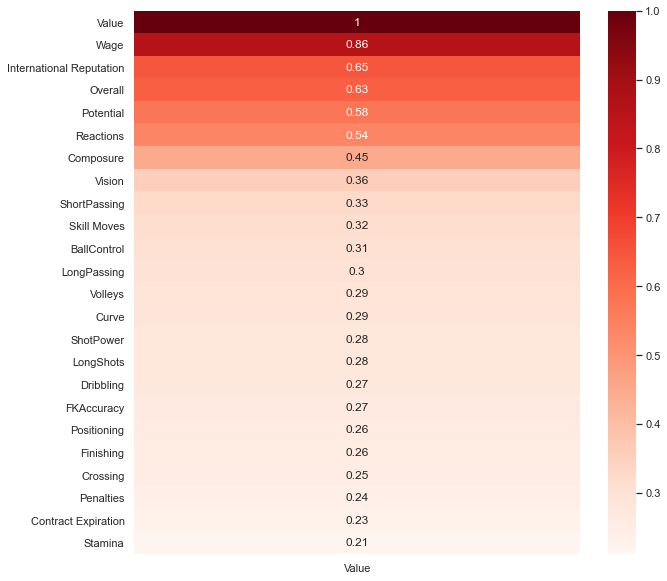

In [52]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr()[['Value']].sort_values('Value', ascending=False).head(24), annot=True, cmap='Reds');

### Dummify Categorical Variables

In [53]:
df_cat = pd.get_dummies(df[['Nationality', 'Club', 'Preferred Foot', 'Work Rate', 'Body Type', 'Main Position']])

In [54]:
df_cat_heatmap = pd.concat([df.Value, df_cat], axis = 1)

### Heatmap for Categorical Features

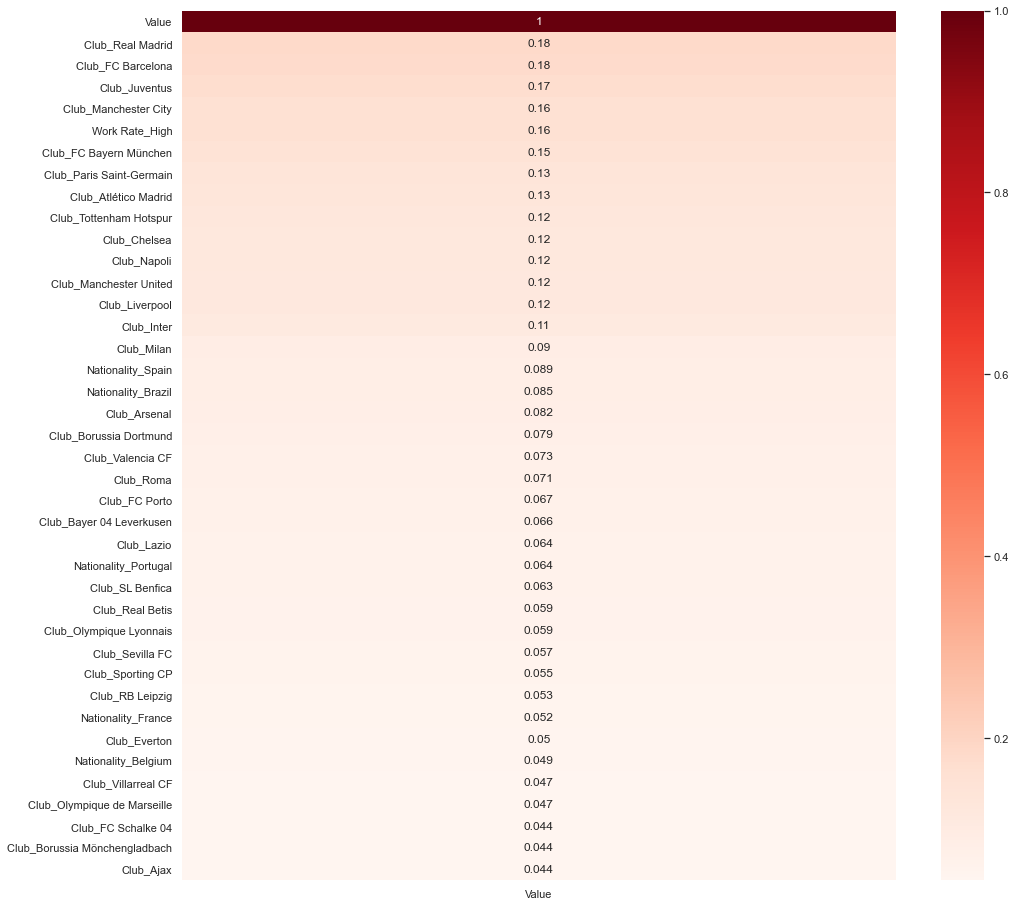

In [55]:
plt.figure(figsize=(16,16))
sns.heatmap(df_cat_heatmap.corr()[['Value']].sort_values('Value', ascending=False).head(40), annot=True, cmap='Reds');

As seen from the heatmap above, the clubs with the highest correlation to a players' value are Real Madrid, Barcelona, Juventus. For work rate, the highest correlations are High/High and High/Medium. As for nationality, players from Spain or Brazil have the highest correlation with value.

## Modeling

For the modeling process, i am going to try out different models to see which model give the best score on unseen data. I will then select the best model and fit it.

The 4 models i will be testing are:
#### (1) Linear Regression
#### (2) Lasso Regression
#### (3) Ridge Regression
#### (4) Random Forest Regression

Firstly, i will assess the baseline score.

In [56]:
# baseline accuracy
print("Baseline Accuracy:", df["Value"].mean())

Baseline Accuracy: 2410695.8861976163


I will take numerical features with >0.2 correlation with the target (Value) and categorical features to test the models.

In [57]:
df_num = df[['ID', 'Wage', 'International Reputation', 'Overall', 'Potential', 'Reactions', 'Composure', 'Vision',
         'ShortPassing', 'Skill Moves', 'BallControl', 'LongPassing', 'Volleys', 'Curve', 'ShotPower',
         'LongShots', 'Dribbling', 'FKAccuracy', 'Positioning', 'Finishing', 'Crossing', 'Penalties', 
          'Contract Expiration', 'Stamina']]

In [58]:
df2 = pd.concat([df_num, df_cat], axis = 1)

In [59]:
df2.head()

ID      Wage  International Reputation  Overall  Potential  Reactions  \
0  158023  565000.0                       5.0       94         94       95.0   
1   20801  405000.0                       5.0       94         94       96.0   
2  190871  290000.0                       5.0       92         93       94.0   
3  193080  260000.0                       4.0       91         93       90.0   
4  192985  355000.0                       4.0       91         92       91.0   

   Composure  Vision  ShortPassing  Skill Moves  ...  Body Type_Normal  \
0       96.0    94.0          90.0          4.0  ...                 0   
1       95.0    82.0          81.0          5.0  ...                 0   
2       94.0    87.0          84.0          5.0  ...                 0   
3       68.0    68.0          50.0          1.0  ...                 0   
4       88.0    94.0          92.0          4.0  ...                 1   

   Body Type_Stocky  Main Position_AM  Main Position_CB  Main Position_CDM  \
0                 0                 0                 0                  0   
1                 1                 0                 0                  0   
2                 0                 0                 0                  0   
3                 0                 0                 0                  0   
4                 0                 0                 0                  0   

   Main Position_CM  Main Position_FB  Main Position_GK  Main Position_ST  \
0                 0                 0                 0                 1   
1                 0                 0                 0                 1   
2                 0                 0                 0                 0   
3                 0                 0                 1                 0   
4                 1                 0                 0                 0   

   Main Position_WING  
0                   0  
1                   0  
2                   1  
3                   0  
4                   0  

[5 rows x 855 columns]

In [60]:
# Redefine X and y
X = df2
y = df['Value']
#X_val =

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [62]:
X_val = X_test.copy()

In [63]:
X_train.drop(['ID'], axis=1, inplace=True)
X_test.drop(['ID'], axis=1, inplace=True)

In [64]:
X_test.head()

Wage  International Reputation  Overall  Potential  Reactions  \
5848    8000.0                       1.0       69         77       66.0   
14634   2000.0                       1.0       61         61       53.0   
11807   3000.0                       1.0       64         68       53.0   
5826   18000.0                       1.0       69         69       66.0   
1989   24000.0                       1.0       75         80       69.0   

       Composure  Vision  ShortPassing  Skill Moves  BallControl  ...  \
5848        41.0    42.0          33.0          1.0         24.0  ...   
14634       60.0    43.0          48.0          2.0         56.0  ...   
11807       42.0    13.0          25.0          1.0         16.0  ...   
5826        73.0    66.0          69.0          2.0         69.0  ...   
1989        68.0    79.0          74.0          3.0         75.0  ...   

       Body Type_Normal  Body Type_Stocky  Main Position_AM  Main Position_CB  \
5848                  1                 0                 0                 0   
14634                 1                 0                 0                 0   
11807                 1                 0                 0                 0   
5826                  0                 0                 0                 1   
1989                  1                 0                 0                 0   

       Main Position_CDM  Main Position_CM  Main Position_FB  \
5848                   0                 0                 0   
14634                  0                 0                 0   
11807                  0                 0                 0   
5826                   0                 0                 0   
1989                   1                 0                 0   

       Main Position_GK  Main Position_ST  Main Position_WING  
5848                  1                 0                   0  
14634                 0                 1                   0  
11807                 1                 0                   0  
5826                  0                 0                   0  
1989                  0                 0                   0  

[5 rows x 854 columns]

In [65]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [66]:
X_train_scaled[:2, :2]

array([[-0.35841632, -0.29551156],
       [-0.4048643 , -0.29551156]])

In [67]:
X_test_scaled[:2, :2]

array([[-0.07972846, -0.29551156],
       [-0.35841632, -0.29551156]])

#### Linear Regression

In [68]:
# Linear Regression
lr = LinearRegression()
lr_cv_train = cross_val_score(lr, X_train_scaled, y_train, cv=5).mean()
lr_cv_train

-5.141149254632236e+25

In [69]:
lr_cv_test = cross_val_score(lr, X_test_scaled, y_test, cv=5).mean()
lr_cv_test

-2.0420590434240957e+26

In [70]:
lr_cv_var = lr_cv_train - lr_cv_test
lr_cv_var

1.5279441179608721e+26

#### Lasso CV

In [71]:
lasso = LassoCV(cv=5)
lasso_cv_train = cross_val_score(lasso, X_train_scaled, y_train, cv=5).mean()
lasso_cv_train

0.8113701917887127

In [72]:
lasso_cv_test = cross_val_score(lasso, X_test_scaled, y_test, cv=5).mean()
lasso_cv_test

0.8123813662146457

In [73]:
lasso_cv_var = lasso_cv_train - lasso_cv_test
lasso_cv_var

-0.0010111744259330147

#### Ridge CV

In [74]:
ridge = RidgeCV()
ridge_cv_train = cross_val_score(ridge, X_train_scaled, y_train, cv=5).mean()
ridge_cv_train

0.8102050487691204

In [75]:
ridge_cv_test = cross_val_score(ridge, X_test_scaled, y_test, cv=5).mean()
ridge_cv_test

0.8130673897116705

In [76]:
ridge_cv_var = ridge_cv_train - ridge_cv_test
ridge_cv_var

-0.0028623409425501123

#### Random Forest

In [77]:
#rf = RandomForestRegressor(n_estimators=150,random_state=42)
rf = RandomForestRegressor(random_state=42)
rf_cv_train = cross_val_score(rf, X_train_scaled, y_train, cv=5).mean()
rf_cv_train 

0.959892639666462

In [78]:
rf_cv_test = cross_val_score(rf, X_test_scaled, y_test, cv=5).mean()
rf_cv_test

0.9531416142627247

In [79]:
rf_cv_var = rf_cv_train - rf_cv_test
rf_cv_var

0.006751025403737287

In [80]:
# Create a df to compare results between models
model_comparison = pd.DataFrame([[lasso_cv_train , ridge_cv_train , rf_cv_train],
                              [lasso_cv_test , ridge_cv_test, rf_cv_test],
                              [lasso_cv_var, ridge_cv_var, rf_cv_var]],
                              columns = ["Lasso Regression", "Ridge Regression","Random Forest"], 
                              index=["Train Score", "Accuracy Score", "Variance"])
model_comparison

Lasso Regression  Ridge Regression  Random Forest
Train Score             0.811370          0.810205       0.959893
Accuracy Score          0.812381          0.813067       0.953142
Variance               -0.001011         -0.002862       0.006751

The above shows a rough illustration of how the models would perform on unrecognised data as they have not been fitted yet. Linear regression is clearly not suitable as it generates a negative train and test score so it is excluded from the table. Lasso and Ridge regression have very close scores but Random Forest produces the best results with the highest accuracy score and lowest variance. These set of results are similar to the test on the first example in terms of each invidual model's performance rankings, with Random Forest being the top scorer in both cases.

## Evaluating Best Model - Random Forest

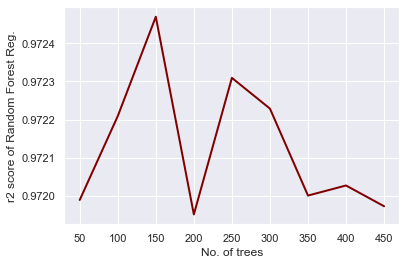

In [81]:
# Finding out the optimal number of trees for Random Forest Regression
# Adapted from aninditakarmakar


forestRange=range(50,500,50)
scores_list=[]
for i in forestRange: 
    rf = RandomForestRegressor(n_estimators=i,random_state=42)
    rf.fit(X_train_scaled,y_train)
    pred_rf  = rf.predict(X_test_scaled)
    scores_list.append(r2_score(y_test,pred_rf))
plt.plot(forestRange,scores_list,linewidth=2,color='maroon')
plt.xticks(forestRange)
plt.xlabel('No. of trees')
plt.ylabel('r2 score of Random Forest Reg.')
plt.show()

As shown above, the best estimator is at n = 150 trees.

### Random Forest

### Using best params

In [82]:
rf = RandomForestRegressor(n_estimators=150,random_state=42)
rf.fit(X_train_scaled,y_train)

RandomForestRegressor(n_estimators=150, random_state=42)

In [83]:
# Generating score
train_rf = rf.score(X_train_scaled, y_train)
print(f'Random Forest Train Score:', train_rf)

accuracy_rf = rf.score(X_test_scaled, y_test)
print(f'Random Forest Accuracy Score:', accuracy_rf)

var_rf = train_rf - accuracy_rf
print(f'Random Forest Variance:', var_rf)

crossval_rf = cross_val_score(rf, X_train_scaled, y_train, cv=5).mean()
print(f'Random Forest Cross Validation Score:', crossval_rf)

Random Forest Train Score: 0.9946033012608357
Random Forest Accuracy Score: 0.9724695770746812
Random Forest Variance: 0.022133724186154558
Random Forest Cross Validation Score: 0.9603803418408884


### Predicting Player's Value

In [84]:
rf_pred = rf.predict(X_test_scaled)
rf_pred[1:10]

array([ 192466.66666667,  413833.33333333,  669966.66666667,
       8696666.66666667, 4776000.        ,  348500.        ,
        478800.        ,  396900.        ,  830500.        ])

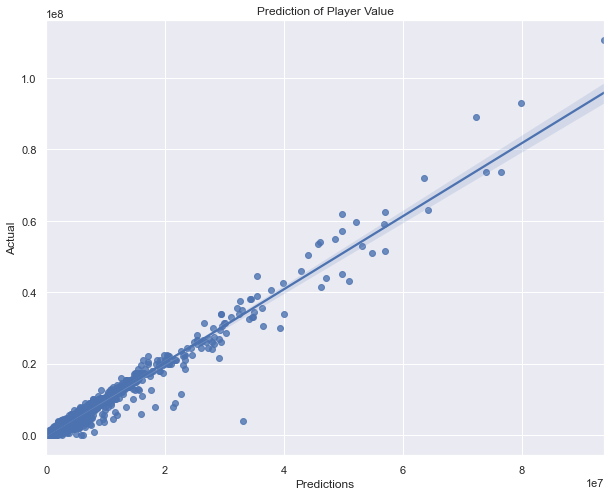

In [85]:
#Visualising the results
plt.figure(figsize=(10,8))
sns.regplot(rf_pred,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Prediction of Player Value")
plt.show()

In [86]:
id_col = pd.DataFrame(X_val.iloc[:,0])
rf_preds = pd.DataFrame(rf_pred)

In [87]:
id_col = id_col.reset_index(drop=True)

In [88]:
#id_col.head(10)

In [89]:
#rf_preds.head(10)

In [90]:
#rf_preds.values/1000

In [91]:
prediction_df = pd.concat([id_col, rf_preds], axis=1)
prediction_df.rename(columns={0: 'Value'}, inplace=True)
prediction_df.head(10)

ID         Value
0  229692  1.181500e+06
1  239605  1.924667e+05
2  214981  4.138333e+05
3  189235  6.699667e+05
4  204497  8.696667e+06
5  237631  4.776000e+06
6  244538  3.485000e+05
7  189839  4.788000e+05
8  226416  3.969000e+05
9  217758  8.305000e+05

Now lets try to match the prediction of some players and compare it against the actual values!

In [92]:
df[df['ID'] == 229692]

ID     Name  Age Nationality  Overall  Potential             Club  \
5848  229692  J. Huth   24     Germany       69         77  1. FSV Mainz 05   

          Value    Wage  Preferred Foot  ...  Composure  Marking  \
5848  1200000.0  8000.0               1  ...       41.0     22.0   

      StandingTackle SlidingTackle GKDiving GKHandling  GKKicking  \
5848            14.0          11.0     70.0       65.0       74.0   

     GKPositioning GKReflexes  Main Position  
5848          66.0       72.0             GK  

[1 rows x 54 columns]

For J.Huth (ID 229692), the predicted value is 1.18m euros while the actual value is 1.2m euroes.

In [93]:
df[df['ID'] == 217758]

ID           Name  Age       Nationality  Overall  Potential  \
9489  217758  C. Washington   26  Northern Ireland       66         69   

                  Club     Value    Wage  Preferred Foot  ...  Composure  \
9489  Sheffield United  825000.0  5000.0               1  ...       60.0   

      Marking  StandingTackle SlidingTackle GKDiving GKHandling  GKKicking  \
9489     46.0            28.0          27.0     12.0       10.0        7.0   

     GKPositioning GKReflexes  Main Position  
9489           8.0       14.0             ST  

[1 rows x 54 columns]

For C. Washington (ID 217758), the predicted value is 825k euros while the actual value is 831k euroes.

In [94]:
df[df['ID'] == 204497]

ID       Name  Age Nationality  Overall  Potential  \
1989  204497  K. Stöger   24     Austria       75         80   

                    Club      Value     Wage  Preferred Foot  ...  Composure  \
1989  Fortuna Düsseldorf  9000000.0  24000.0               0  ...       68.0   

      Marking  StandingTackle SlidingTackle GKDiving GKHandling  GKKicking  \
1989     38.0            29.0          35.0     15.0       12.0       13.0   

     GKPositioning GKReflexes  Main Position  
1989          10.0       12.0            CDM  

[1 rows x 54 columns]

### Residuals

Now let's plot the residuals to see how well the model has done.

In [95]:
residuals = y_test - rf_pred
residuals[:7]

5848      18500.000000
14634     77533.333333
11807    -13833.333333
5826     105033.333333
1989     303333.333333
3411     124000.000000
13263    -23500.000000
Name: Value, dtype: float64

Text(0.5, 1.0, 'Residual Distribution')

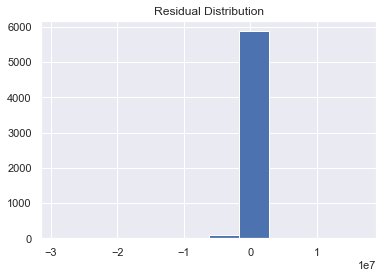

In [96]:
plt.hist(residuals)
plt.title('Residual Distribution')

In [97]:
#plt.hist(np.log(y_test))
#plt.title('Transformed Residuals')


In [98]:
sample_value = y_test.values[0]
np.log(sample_value)

13.997832114758229

In [99]:
np.log(y_test).values.min()

-inf

Text(0.5, 1.0, 'Residuals vs Predictions')

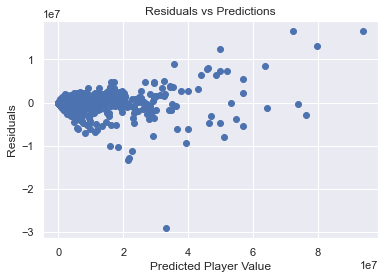

In [100]:
plt.scatter(x=rf_pred, y=residuals)
plt.xlabel('Predicted Player Value')
plt.ylabel('Residuals')
plt.title('Residuals vs Predictions')

### Feature Importance

In [101]:
#https://mljar.com/blog/feature-importance-in-random-forest/

In [37]:
#len(rf.feature_importances_)

In [38]:
#rf.feature_importances_

## Conclusion

In conclusion,
